In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import cv2

from Model.model_hgsr import HourGlassNetMultiScaleInt
from loss import get_content_loss, GW_loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


# Data

X: (1800, 2800, 3)
Y: (3600, 5600, 3)


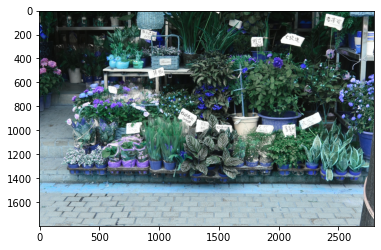

In [2]:
X = cv2.imread('/Users/emrecanacikgoz/Desktop/Vision/DSC_1474_x1.png')
Y = cv2.imread('/Users/emrecanacikgoz/Desktop/Vision/DSC_1474_x2.png')
plt.imshow(X);
print(f"X: {X.shape}")
print(f"Y: {Y.shape}")

lr_son: (900, 1400, 3)


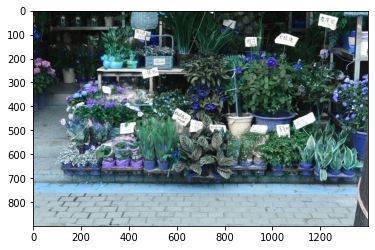

In [3]:
# Bi-CUBIC interpolation
lr_son = cv2.resize(X, None,fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
plt.imshow(lr_son);
print(f"lr_son: {lr_son.shape}")

In [4]:
lr_son_tensor = torch.FloatTensor(lr_son)
lr_father_tensor = torch.FloatTensor(X)
HR_tensor = torch.FloatTensor(Y)
print(f"lr_son_tensor type: {lr_son_tensor.type()}, lr_father_tensor type: {lr_father_tensor.type()}, HR_tensor type: {HR_tensor.type()}")

lr_son_tensor type: torch.FloatTensor, lr_father_tensor type: torch.FloatTensor, HR_tensor type: torch.FloatTensor


In [5]:
print(f"lr_son: {lr_son_tensor.shape}, lr_father: {lr_father_tensor.shape}, HR: {HR_tensor.shape}")
lr_son, lr_father, HR = lr_son_tensor.unsqueeze(0), lr_father_tensor.unsqueeze(0), HR_tensor.unsqueeze(0)
print(f"lr_son: {lr_son.shape}, lr_father: {lr_father.shape}, HR: {HR.shape}")

lr_son: torch.Size([900, 1400, 3]), lr_father: torch.Size([1800, 2800, 3]), HR: torch.Size([3600, 5600, 3])
lr_son: torch.Size([1, 900, 1400, 3]), lr_father: torch.Size([1, 1800, 2800, 3]), HR: torch.Size([1, 3600, 5600, 3])


In [6]:
lr_son, lr_father, HR = lr_son.permute(0, 3, 1, 2), lr_father.permute(0, 3, 1, 2), HR.permute(0, 3, 1, 2)
print(f"lr_son: {lr_son.shape}, lr_father: {lr_father.shape}, HR: {HR.shape}")

lr_son: torch.Size([1, 3, 900, 1400]), lr_father: torch.Size([1, 3, 1800, 2800]), HR: torch.Size([1, 3, 3600, 5600])


# Training

In [8]:
EPOCHS = 10
LR = 1e-3

In [9]:
model = HourGlassNetMultiScaleInt(in_nc=3, 
                                  out_nc=3, 
                                  upscale=2,
                                  nf=64,  
                                  n_mid=1,
                                 )
model.to(device)
optim = optim.Adam(model.parameters(), lr=LR)

In [ ]:
for epoch in range(EPOCHS):
    
    lr_FATHER = (0.257*lr_father[:, :1, :, :] + 0.564*lr_father[:, 1:2, :, :] + 0.098*lr_father[:, 2:, :, :] + 16/255.0) * 255.0
    map_corner = lr_FATHER.new(lr_FATHER.shape).fill_(0)
    map_edge = lr_FATHER.new(lr_FATHER.shape).fill_(0)
    map_flat = lr_FATHER.new(lr_FATHER.shape).fill_(0)
    lr_FATHER_numpy = np.transpose(lr_FATHER.numpy(), (0, 2, 3, 1))
    for i in range(lr_FATHER_numpy.shape[0]):
        dst = cv2.cornerHarris(lr_FATHER_numpy[i, :, :, 0], 3, 3, 0.04)
        thres1 = 0.01*dst.max()
        thres2 = -0.001*dst.max()
        map_corner[i, :, :, :] = torch.from_numpy(np.float32(dst > thres1))
        map_edge[i, :, :, :] = torch.from_numpy(np.float32(dst < thres2))
        map_flat[i, :, :, :] = torch.from_numpy(np.float32((dst > thres2) & (dst < thres1)))
    map_corner = map_corner.to(device)
    map_edge = map_edge.to(device)
    map_flat = map_flat.to(device)
    coe_list = []
    coe_list.append(map_flat)
    coe_list.append(map_edge)
    coe_list.append(map_corner)
    
    sr_var, SR_map = model(lr_son.to(device))
    
    sr_loss = 0
    if isinstance(sr_var, list):
        #sr_loss = 0
        for i in range(len(sr_var)):
            if i != len(sr_var) - 1:
                coe = coe_list[i]
                single_srloss = opt.inte_loss_weight[i] * content_criterion(coe*sr_var[i], coe*lr_father)
            else:
                single_srloss = opt.inte_loss_weight[i] * GW_loss(sr_var[i], lr_father)
            sr_loss += single_srloss
    else:
        sr_loss = content_criterion(sr_var, lr_father)
        
    optim.zero_grad()
    loss.backward()
    optim_.step()
    print(f"Epoch: {epoch}/{Epochs}, loss:{sr_loss}")

x: torch.Size([1, 128, 450, 700]), res: torch.Size([1, 128, 450, 700])
x: torch.Size([1, 128, 900, 1400]), res: torch.Size([1, 128, 900, 1400])
x: torch.Size([1, 128, 450, 700]), res: torch.Size([1, 128, 450, 700])
x: torch.Size([1, 128, 900, 1400]), res: torch.Size([1, 128, 900, 1400])
x: torch.Size([1, 128, 450, 700]), res: torch.Size([1, 128, 450, 700])
x: torch.Size([1, 128, 900, 1400]), res: torch.Size([1, 128, 900, 1400])
x: torch.Size([1, 128, 450, 700]), res: torch.Size([1, 128, 450, 700])
x: torch.Size([1, 128, 900, 1400]), res: torch.Size([1, 128, 900, 1400])
